First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

# The Assignment mainly take references from the following github:
https://github.com/rndbrtrnd/udacity-deep-learning/blob/master/1_notmnist.ipynb
https://github.com/hankcs/udacity-deep-learning/blob/master/1_notmnist.py#L389

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [117]:
'''
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

'''

'''
url = http://yaroslavvb.com/upload/notMNIST/
'''
data_root = r'D:\GitHub\Data\notMNIST'
train_filename = r'D:\GitHub\Data\notMNIST\notMNIST_large.tar.gz'
test_filename = r'D:\GitHub\Data\notMNIST\notMNIST_small.tar.gz'

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
          'Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for D:\GitHub\Data\notMNIST\notMNIST_large. This may take a while. Please wait.
['D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\A', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\B', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\C', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\D', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\E', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\F', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\G', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\H', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\I', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_large\\J']
Extracting data for D:\GitHub\Data\notMNIST\notMNIST_small. This may take a while. Please wait.
['D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\A', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\B', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\C', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\D', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\E', 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\F', 'D:\\GitHub\\Data\\not

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [10]:
for f in train_folders:
    print(f)

D:\GitHub\Data\notMNIST\notMNIST_large\A
D:\GitHub\Data\notMNIST\notMNIST_large\B
D:\GitHub\Data\notMNIST\notMNIST_large\C
D:\GitHub\Data\notMNIST\notMNIST_large\D
D:\GitHub\Data\notMNIST\notMNIST_large\E
D:\GitHub\Data\notMNIST\notMNIST_large\F
D:\GitHub\Data\notMNIST\notMNIST_large\G
D:\GitHub\Data\notMNIST\notMNIST_large\H
D:\GitHub\Data\notMNIST\notMNIST_large\I
D:\GitHub\Data\notMNIST\notMNIST_large\J


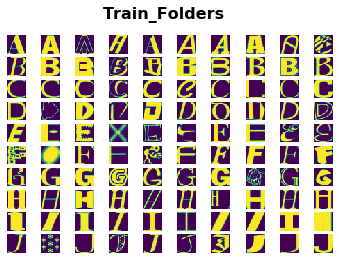

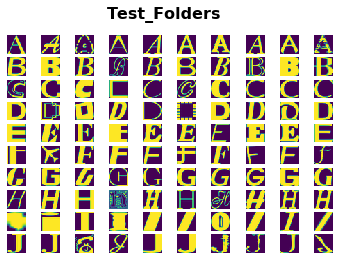

In [14]:
import matplotlib.image as mpimg

# use IPython display images
def image_sample(data_folders, sample_size):
    for folder in data_folders:
        image_files = os.listdir(folder)
        image_samples = random.sample(image_files, sample_size)
        for image in image_samples:
            image_file = os.path.join(folder, image)
            display(Image(image_file))
            
#image_sample(train_folders, 10)

# use matplot to plot images
def plot_sample(data_folders, sample_size, title=None):
    fig = plt.figure()
    
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for folder in data_folders:
        image_files = os.listdir(folder)
        image_sample = random.sample(image_files, sample_size)
        for image in image_sample:
            image_file = os.path.join(folder, image)
            ax = fig.add_subplot(len(data_folders), 
                                 sample_size,
                                 sample_size * data_folders.index(folder) + image_sample.index(image) + 1)
            image = mpimg.imread(image_file)
            ax.imshow(image)
            ax.set_axis_off()

    plt.show()
    
plot_sample(train_folders, 10, 'Train_Folders')
plot_sample(test_folders, 10, 'Test_Folders')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [18]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling D:\GitHub\Data\notMNIST\notMNIST_large\A.pickle.
D:\GitHub\Data\notMNIST\notMNIST_large\A
Could not read: D:\GitHub\Data\notMNIST\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: D:\GitHub\Data\notMNIST\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: D:\GitHub\Data\notMNIST\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825024
Standard deviation: 0.44312063
Pickling D:\GitHub\Data\notMNIST\notMNIST_large\B.pickle.
D:\GitHub\Data\notMNIST\notMNIST_large\B
Could not read: D:\GitHub\Data\notMNIST\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skippi

In [3]:
# train_datasets

# read pickle file
def read_pickle_file(path):
    datasets = []
    files = os.listdir(path)
    for file in files:
        if 'pickle' in file:
            datasets.append(path + '\\' + file)
    return datasets

pickle_train_datasets = read_pickle_file(r'D:\GitHub\Data\notMNIST\notMNIST_large')
pickle_test_datasets = read_pickle_file(r'D:\GitHub\Data\notMNIST\notMNIST_small')

In [4]:
pickle_test_datasets

['D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\A.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\B.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\C.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\D.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\E.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\F.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\G.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\H.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\I.pickle',
 'D:\\GitHub\\Data\\notMNIST\\notMNIST_small\\J.pickle']

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [14]:
# generate fake labels
def generate_labels(sizes):
    labels = np.ndarray(sum(sizes), dtype=np.int32)
    start = 0
    end = 0
    for label, size in enumerate(sizes):
        start = end
        end += size
        for i in range(start, end):
            labels[i] = label
    return labels

In [92]:
# subplot(nrows, ncols, index, **kwargs)

def display_sample(dataset, sample_size, title=None):
    fig = plt.figure()
    
    if title: fig.suptitle(title)
    num_of_images = []
    for pickle_file in dataset:
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            print('Total images in ', pickle_file, ': ', len(data))
            
            for index, image in enumerate(data):
                if index == sample_size: break
                ax = fig.add_subplot(len(dataset), sample_size, sample_size * dataset.index(pickle_file) + index + 1)
                ax.imshow(image)
                ax.set_axis_off()
                ax.imshow(image)
            num_of_images.append(len(data))
    
    # add check balance
    check_balance(num_of_images)
    plt.show()
    return num_of_images

Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\A.pickle :  52909
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\B.pickle :  52911
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\C.pickle :  52912
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\D.pickle :  52911
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\E.pickle :  52912
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\F.pickle :  52912
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\G.pickle :  52912
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\H.pickle :  52912
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\I.pickle :  52912
Total images in  D:\GitHub\Data\notMNIST\notMNIST_large\J.pickle :  52911
mean of images:  52911.4
Well balanced  52909
Well balanced  52911
Well balanced  52912
Well balanced  52911
Well balanced  52912
Well balanced  52912
Well balanced  52912
Well balanced  52912
Well balanced  52912
Well balanced  52911


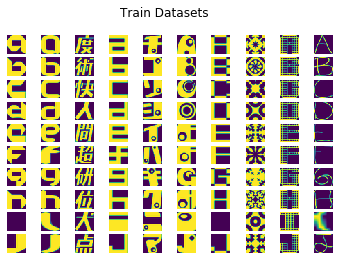

Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\A.pickle :  1872
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\B.pickle :  1873
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\C.pickle :  1873
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\D.pickle :  1873
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\E.pickle :  1873
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\F.pickle :  1872
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\G.pickle :  1872
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\H.pickle :  1872
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\I.pickle :  1872
Total images in  D:\GitHub\Data\notMNIST\notMNIST_small\J.pickle :  1872
mean of images:  1872.4
Well balanced  1872
Well balanced  1873
Well balanced  1873
Well balanced  1873
Well balanced  1873
Well balanced  1872
Well balanced  1872
Well balanced  1872
Well balanced  1872
Well balanced  1872


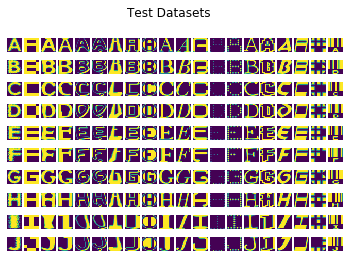

In [95]:
train_labels = generate_labels(display_sample(pickle_train_datasets, 10, 'Train Datasets'))
test_labels = generate_labels(display_sample(pickle_test_datasets, 20, 'Test Datasets'))

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [85]:
def plot_balance():
    fig, ax = plt.subplots(1, 2)
    bins = np.arange(train_labels.min(), train_labels.max() + 2)
    ax[0].hist(train_labels, bins=bins)
    ax[0].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[0].set_title("Training data")
    
    bins = np.arange(test_labels.min(), test_labels.max() + 2)
    ax[1].hist(test_labels, bins=bins)
    ax[1].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[1].set_title("Test data")
    plt.show()

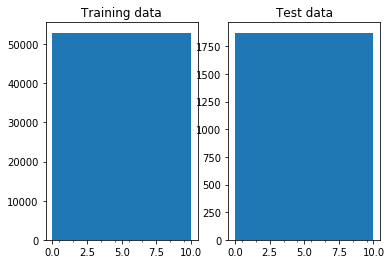

In [86]:
plot_balance = plot_balance()

In [81]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [94]:
def check_balance(sizes):
    mean_val  = mean(sizes)
    print('mean of images: ', mean_val)
    for i in sizes:
        if abs(i - mean_val) > 0.1 * mean_val:
            print('Too much or less images')
        else:
            print('Well balanced ', i)

In [91]:
# check_balance(display_sample(pickle_train_datasets, 10, 'Train Datasets'))

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [6]:
image_size = 28

def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
              print('Unable to process data from', pickle_file, ':', e)
              raise

    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  pickle_train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(pickle_test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [7]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [10]:
def plot_shuffle_dataset(dataset, labels, title=None):
    plt.suptitle(title)
    
    items = random.sample(range(len(labels)), 20)
    for i, item in enumerate(items):
        plt.subplot(4, 5, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset[item])
    plt.show()

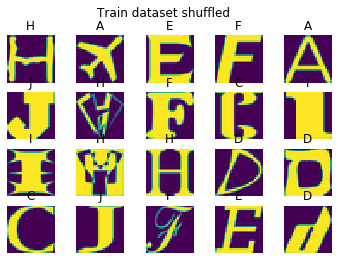

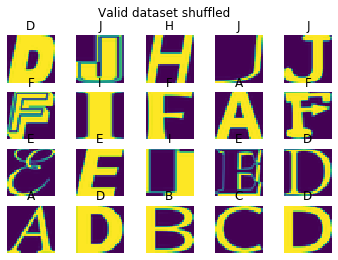

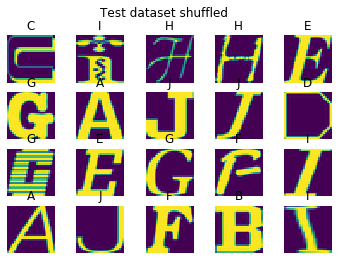

In [116]:
plot_shuffle_dataset(train_dataset, train_labels, 'Train dataset shuffled')
plot_shuffle_dataset(valid_dataset, valid_labels, 'Valid dataset shuffled')
plot_shuffle_dataset(test_dataset, test_labels, 'Test dataset shuffled')

Finally, let's save the data for later reuse:

In [118]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [119]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [122]:
import hashlib

def extract_overlap(dataset_1, dataset_2):
    dataset_hash1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash1):
        duplicates = np.where(dataset_hash2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [123]:
%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)

Wall time: 2.54 s


In [124]:
print('Numbers of overlaps: ', len(overlap_test_train.keys()))

Numbers of overlaps:  23


In [130]:
overlap_test_train.keys()

dict_keys([20, 23, 35, 37, 40, 51, 59, 66, 76, 82, 87, 92, 116, 125, 130, 133, 150, 165, 169, 173, 178, 181, 185])

In [213]:
def display_overlap(overlap, source_dataset, target_dataset):
    item = random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i + 1)
        plt.title(item)
        plt.axis('off')
        plt.imshow(img)

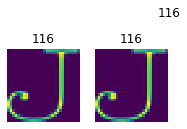

In [214]:
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [215]:
def sanetize(dataset_1, dataset_2, labels):
    dataset_hash1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []
    for i, hash1 in enumerate(dataset_hash1):
        duplicates = np.where(dataset_hash2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(labels, overlap, None)

In [217]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanit))

Wall time: 44 s
Overlapping images removed:  1285


In [218]:
%time valid_dataset_sanit, valid_labels_sanit = sanetize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

Wall time: 44.3 s
Overlapping images removed:  1015


In [219]:
pickle_sanit_file =  r'D:\GitHub\Data\notMNIST\notMNIST_sanit.pickle'

try:
    f = open(pickle_sanit_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data: ', e)
    raise

In [221]:
statinfo = os.stat(pickle_sanit_file)
print('Compressed pickle size: ', statinfo.st_size)

Compressed pickle size:  683578506


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [8]:
regr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [9]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]

%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 99.7 ms


0.6022

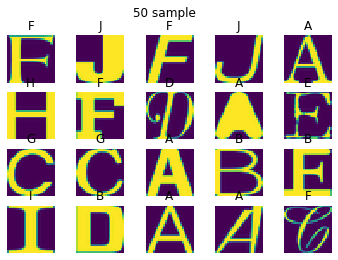

In [12]:
pred_labels = regr.predict(X_test)
plot_shuffle_dataset(test_dataset, pred_labels, "50 sample")

In [13]:
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]

%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Wall time: 92.7 ms


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7795

In [14]:
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]

%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 1.74 s


0.8381

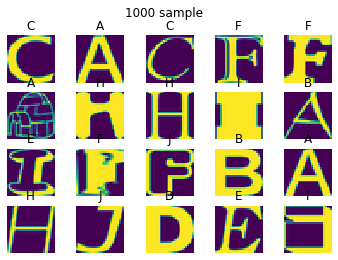

In [15]:
pred_labels = regr.predict(X_test)
plot_shuffle_dataset(test_dataset, pred_labels, "1000 sample")

In [16]:
len(train_dataset)

200000

In [17]:
# Train all data

regr2 = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]

%time regr2.fit(X_train, y_train)
regr2.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Wall time: 19min 19s


0.8937

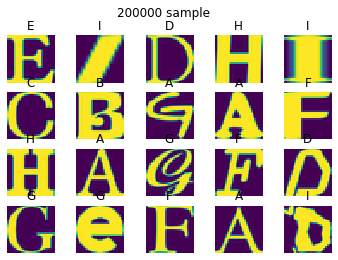

In [19]:
pred_labels = regr2.predict(X_test)
plot_shuffle_dataset(test_dataset, pred_labels, "200000 sample")